# Chest and breast classification

In [39]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, auc, confusion_matrix
from matplotlib import pyplot as plt
from torchsummary import summary

import medmnist
from medmnist import INFO

## 2D breast ultrasound classification.

## Dataloading
We first load a 2D dataset breast ultrasound dataset-BreastMNIST, preprocess it and encapsulate it into dataloader form.

In [40]:
data_flag_2d = 'breastmnist' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_2d] # INFO is embedded in the medmnist containing basic information of datasets
print(info)
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1', 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364', 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1', 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1', 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1', 'MD5_224': 'b5637

In [41]:
# hyparameters
BATCH_SIZE = 32
EPOCH_NUM = 20
lr = 0.00001

In [ ]:
# preprocessing such as conversion to tensor and normalization
data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5], std=[.5])])

# get the data class
DataClass = getattr(medmnist, info['python_class'])

# encapsulate datasets into Dataloader form
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)

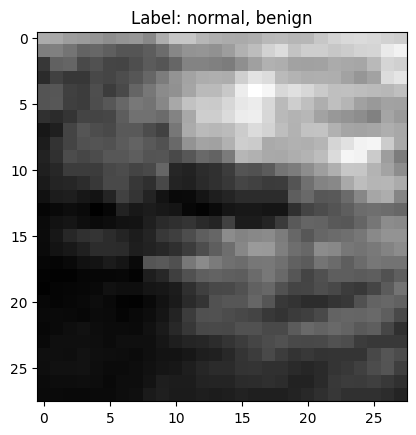

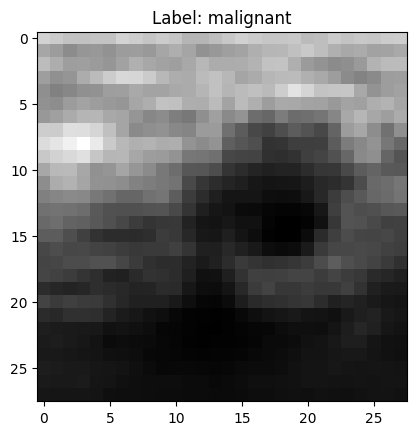

In [44]:
# query images and corresponding labels
im_1, label_1 = train_dataset[50]
im_2, label_2 = test_dataset[20]

# visualization
plt.imshow(im_1.squeeze(), cmap='gray')
label1 = train_dataset.info['label'][f"{label_1.item()}"]
label2 = train_dataset.info['label'][f"{label_2.item()}"]

plt.title(f'Label: {label1}')
plt.show()

plt.imshow(im_2.squeeze(), cmap='gray')
plt.title(f'Label: {label2}')
plt.show()


## Model implemententation

In [45]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.0)
        self.fc2 = nn.Linear(128, num_classes)


    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

cnn_model = CNN(n_channels, 1)
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=1e-4)


Here shows the summary of designed CNN architecture.

In [46]:
"""
Here shows the summary of the model you designed with input size of your data and batch size you chose.
Please pass the size of data size to SAMPLE_DATASIZE.
"""
SAMPLE_DATASIZE = (1,28,28)
summary(cnn_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 16, 28, 28]             160
       BatchNorm2d-2           [32, 16, 28, 28]              32
         MaxPool2d-3           [32, 16, 14, 14]               0
            Conv2d-4           [32, 32, 14, 14]           4,640
       BatchNorm2d-5           [32, 32, 14, 14]              64
         MaxPool2d-6             [32, 32, 7, 7]               0
            Conv2d-7             [32, 64, 7, 7]          18,496
       BatchNorm2d-8             [32, 64, 7, 7]             128
            Conv2d-9            [32, 128, 7, 7]          73,856
      BatchNorm2d-10            [32, 128, 7, 7]             256
           Conv2d-11            [32, 256, 7, 7]         295,168
      BatchNorm2d-12            [32, 256, 7, 7]             512
           Linear-13                  [32, 128]       1,605,760
          Dropout-14                  [

## Training and evaluation

Please fill the blanks in train and test functions.

In [47]:
# train and validation
def train(train_loader, val_loader, model):
    model.train()
    train_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float()).squeeze()
        loss = criterion(outputs, labels.float().squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.float()).squeeze()
            loss = criterion(outputs, labels.float().squeeze())
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)

    return train_loss, val_loss, model

# test
def test(test_loader, model):
    model.eval()
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.float()).squeeze(1).cpu().numpy()
            y_scores.extend(outputs)
            y_true.extend(labels.cpu().numpy())
            
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_value = auc(fpr, tpr)
    acc = ((np.array(y_scores) > 0.4).astype(int) == np.array(y_true)).mean()
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_value, acc

Epoch 1/25 => Train loss: 0.5970, Validation loss: 0.6336
Epoch 2/25 => Train loss: 0.5394, Validation loss: 0.5872
Epoch 3/25 => Train loss: 0.5079, Validation loss: 0.5247
Epoch 4/25 => Train loss: 0.4825, Validation loss: 0.4912
Epoch 5/25 => Train loss: 0.4593, Validation loss: 0.4735
Epoch 6/25 => Train loss: 0.4417, Validation loss: 0.4539
Epoch 7/25 => Train loss: 0.4239, Validation loss: 0.4352
Epoch 8/25 => Train loss: 0.4041, Validation loss: 0.4220
Epoch 9/25 => Train loss: 0.3904, Validation loss: 0.4085
Epoch 10/25 => Train loss: 0.3741, Validation loss: 0.3991
Epoch 11/25 => Train loss: 0.3547, Validation loss: 0.3849
Epoch 12/25 => Train loss: 0.3383, Validation loss: 0.3748
Epoch 13/25 => Train loss: 0.3268, Validation loss: 0.3702
Epoch 14/25 => Train loss: 0.3111, Validation loss: 0.3527
Epoch 15/25 => Train loss: 0.2932, Validation loss: 0.3393
Epoch 16/25 => Train loss: 0.2802, Validation loss: 0.3310
Epoch 17/25 => Train loss: 0.2727, Validation loss: 0.3229
Epoch 

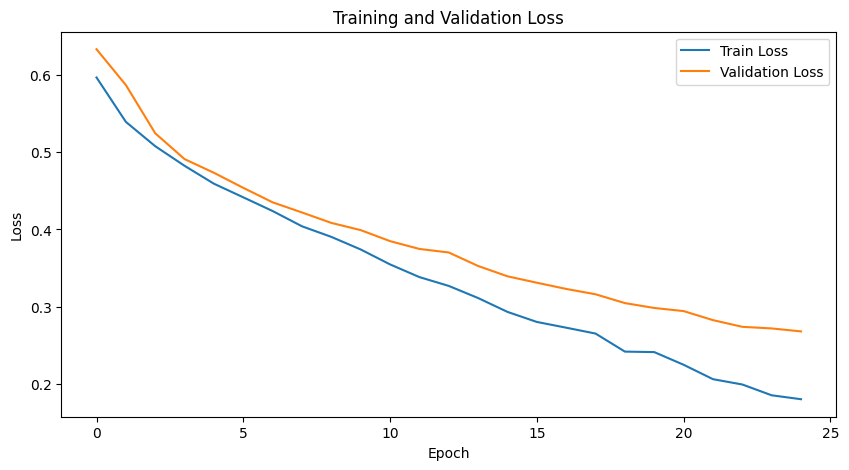

In [48]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
EPOCH_NUM = 25

# train
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCH_NUM):
    train_loss, val_loss, cnn_model = train(train_loader, val_loader, cnn_model)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    print(f'Epoch {epoch+1}/{EPOCH_NUM} => '
          f'Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')


# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

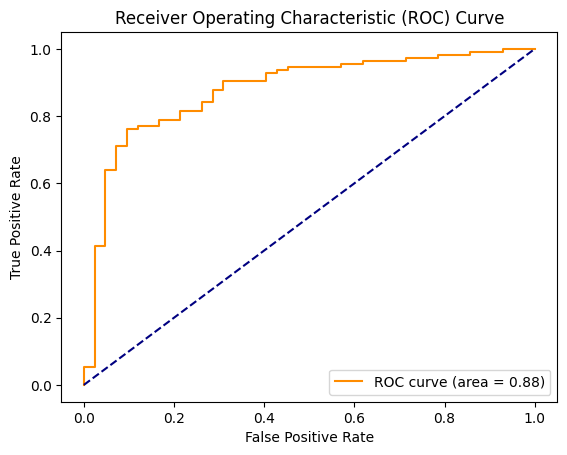

auc: 0.878, acc: 0.663


In [53]:
# test
area_under_curve, acc = test(test_loader, cnn_model)


print(f'auc: {area_under_curve:.3f}, acc: {acc:.3f}')


# 3D dataset NoduleMNIST3D

In [ ]:
# hyparameters
BATCH_SIZE = 64
EPOCH_NUM = 10
lr = 0.0001

# dataset
data_flag_3d = 'nodulemnist3d' # here the name of dataset should be passed.
download = True

info = INFO[data_flag_3d]
print(info)
task = info['task']

n_channels = info['n_channels']
n_classes = 1

# get the data class without transform
DataClass = getattr(medmnist, info['python_class'])

# encapsulate datasets into Dataloader form
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

# show the details
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)
train_dataset.montage(length=20)[10]

## 3D CNN implementation

In [59]:
class CNN_3D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(2)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(2)
        self.conv4 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(128)
        self.pool4 = nn.MaxPool3d(2)
        self.conv5 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm3d(256)
        self.dropout = nn.Dropout(0.8)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))  # Removed the last pooling layer
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# initialize the 3D model
cnn3d_model = CNN_3D(n_channels, n_classes)

# define the BCE loss function and an optimizer you prefer
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn3d_model.parameters(), lr=lr, weight_decay=1e-4)

# show the details
SAMPLE_DATASIZE =  (1,28,28,28)
summary(cnn3d_model, SAMPLE_DATASIZE, BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [64, 16, 28, 28, 28]             448
       BatchNorm3d-2       [64, 16, 28, 28, 28]              32
         MaxPool3d-3       [64, 16, 14, 14, 14]               0
            Conv3d-4       [64, 32, 14, 14, 14]          13,856
       BatchNorm3d-5       [64, 32, 14, 14, 14]              64
         MaxPool3d-6          [64, 32, 7, 7, 7]               0
            Conv3d-7          [64, 64, 7, 7, 7]          55,360
       BatchNorm3d-8          [64, 64, 7, 7, 7]             128
         MaxPool3d-9          [64, 64, 3, 3, 3]               0
           Conv3d-10         [64, 128, 3, 3, 3]         221,312
      BatchNorm3d-11         [64, 128, 3, 3, 3]             256
        MaxPool3d-12         [64, 128, 1, 1, 1]               0
           Conv3d-13         [64, 256, 1, 1, 1]         884,992
      BatchNorm3d-14         [64, 256, 

## Training and evaluation

Epoch 1/10 => Train loss: 0.6491, Validation loss: 0.6605
Epoch 2/10 => Train loss: 0.5598, Validation loss: 0.5827
Epoch 3/10 => Train loss: 0.5192, Validation loss: 0.4942
Epoch 4/10 => Train loss: 0.4779, Validation loss: 0.4584
Epoch 5/10 => Train loss: 0.4318, Validation loss: 0.4098
Epoch 6/10 => Train loss: 0.3965, Validation loss: 0.3978
Epoch 7/10 => Train loss: 0.3763, Validation loss: 0.3860
Epoch 8/10 => Train loss: 0.3255, Validation loss: 0.3835
Epoch 9/10 => Train loss: 0.3258, Validation loss: 0.3598
Epoch 10/10 => Train loss: 0.2922, Validation loss: 0.3539


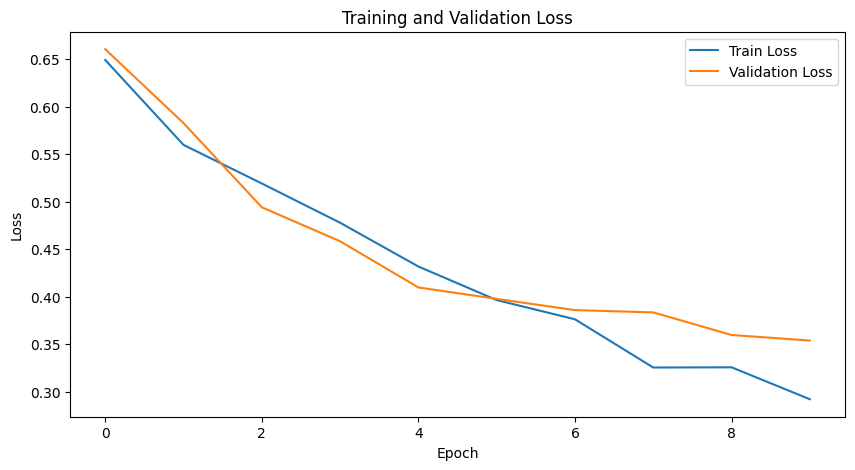

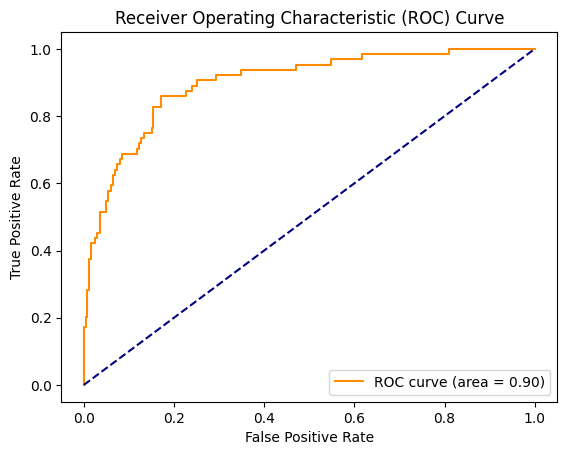

auc: 0.899, acc: 0.686


In [60]:
"""
Here shows the training and validation curves. AUC and ACC of test will also be printed.
"""
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# train
train_loss_values = []
val_loss_values = []

for epoch in range(EPOCH_NUM):
    train_loss, val_loss, cnn3d_model = train(train_loader, val_loader, cnn3d_model)
    train_loss_values.append(train_loss)
    val_loss_values.append(val_loss)
    print(f'Epoch {epoch+1}/{EPOCH_NUM} => '
          f'Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}')


# show training and validation curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


# test
area_under_curve, acc = test(test_loader, cnn3d_model)

print(f'auc: {area_under_curve:.3f}, acc: {acc:.3f}')